# M4101, Analyse de données, classification
### Cedric Chauve, cedric.chauve@sfu.ca

## Préliminaires

Dans ce calepin, nous allons explorer le problème de classification binaire supervisée sur un vrai jeu de données, auquel on va appliquer la technique de réduction de dimensionalité de l'Analyse en Composantes Principales. 

In [1]:
import numpy as np
import pandas as pa
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import sklearn

## Chargement des données

Les données que nous allons analyser font partie des exemples fournis avec Scikit-learn, on peut donc les charger facilement.

In [2]:
from sklearn.datasets import load_breast_cancer

Les datasets de Scikit-klearn sont, en général, bien formatés. Ils viennent avec une structure permettant de les visualiser et de les "fouiller" facilement. 

In [3]:
breast_cancer = load_breast_cancer()

print(breast_cancer.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [4]:
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

Pour résumer, on a une matrice de données pour 569 patients, et pour chaque patient, on a extrait d'images médicales 30 mesures géométriques sur les cellules observées sur ces images. On a donc une matrice de taille 569x30.

In [12]:
print('Nom des mesures géométriques :\n'+str(breast_cancer.feature_names))
print()
print('Valeur des mesures géométriques pour le premier patient :\n'+str(breast_cancer.data[0]))

Nom des mesures géométriques :
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Valeur des mesures géométriques pour le premier patient :
[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]


On peut voir que les données peuvent etre divisées en 10 catégories, et pour chacune on extrait trois attributs (valeur moyenne, déviation standard, valeur maximale). Pour nous simplifier la tâche, nous allons nous contenter des valeurs moyennes, donc de 10 attributs.

In [19]:
# Liste des attributs que nous allons prendre en compte.
ATTRIBUTS = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension']
# Nombre d'attributs
NB_ATT = len(ATTRIBUTS) 
# Attributs et donnees, encodes sous la forme d'une data frame pandas
X      = pa.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)[ATTRIBUTS]

In [20]:
print('Début de la data frame contenant les 10 attributs pris en compte pour chaque patient')
X.head()

Début de la data frame contenant les 10 attributs pris en compte pour chaque patient


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


On peut donc voir les données mesurées sur chaque patiente que l'on va prendre en cmpte comme une grosse **matrice** de 
- 569 lignes, chacune représentant une patiente (un **point de données**)
- 10 colonnes, chacune représentant un **attribut**
Chaque point de données est donc représenté par un vecteur de 10 attributs.   
Notez cependant que X est une data frame (les lignes et colonnes ont un label) et non pas une simple matrice.  
Si on voulait avoir une matrice, on devrait convertir dans le type "array" de numpy (np.array(X)).

Pour faire de la classification, nous devons aussi connaître la nature de la tumeur de chaque patiente. Pour chaque patient, on connait la nature de sa tumeur, maligne ou bénigne. Cette information est stockée dans le champ *target* du jeu de données, un vecteur binaire (classe 0 pour tumeur maligne et classe 1 pour tumeur bénigne).

In [23]:
print(breast_cancer.target_names)
print(breast_cancer.target)
for i in range(20,25):
    print('Patient '+str(i)+' has a '+str(breast_cancer.target_names[breast_cancer.target[i]])+' tumor')

['malignant' 'benign']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1

In [26]:
# y : data frame encodant la classe de la tumeur
y = pa.Categorical.from_codes(breast_cancer.target, breast_cancer.target_names)
y = pa.get_dummies(y, drop_first=True)
# y01: vecteur binaire indiquant la classe de chaque point de donnee (1 = benigne, 0 = maligne)
y01 = np.array(breast_cancer.target)

On a donc un vecteur binaire y01 de 569 entrées représenant la classe de la tumeur de chaque patiente. 

## But : classifier des tumeurs

Le but que nous poursuivons consiste à développer un classifieur qui étant donné les données proventn d'une nouvelle patiente, va pouvoir prédire si sa tumeur est maligne ou bénigne.

## Analyse préliminaire des données

Nous passons maintenant à une exploration statistique mais visuelle des attributs géométriques encodes dans notre matrice de données X.  
Pour cela nous allons utiliser deux commandes de pandas, *hist* qui permet de générer un histogramme des valeurs par attribut et *boxplot* qui génère une <a href="https://fr.wikipedia.org/wiki/Bo%C3%AEte_%C3%A0_moustaches">boîte à moustache</a> par attribut.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa393326470>,
      dtype=object)

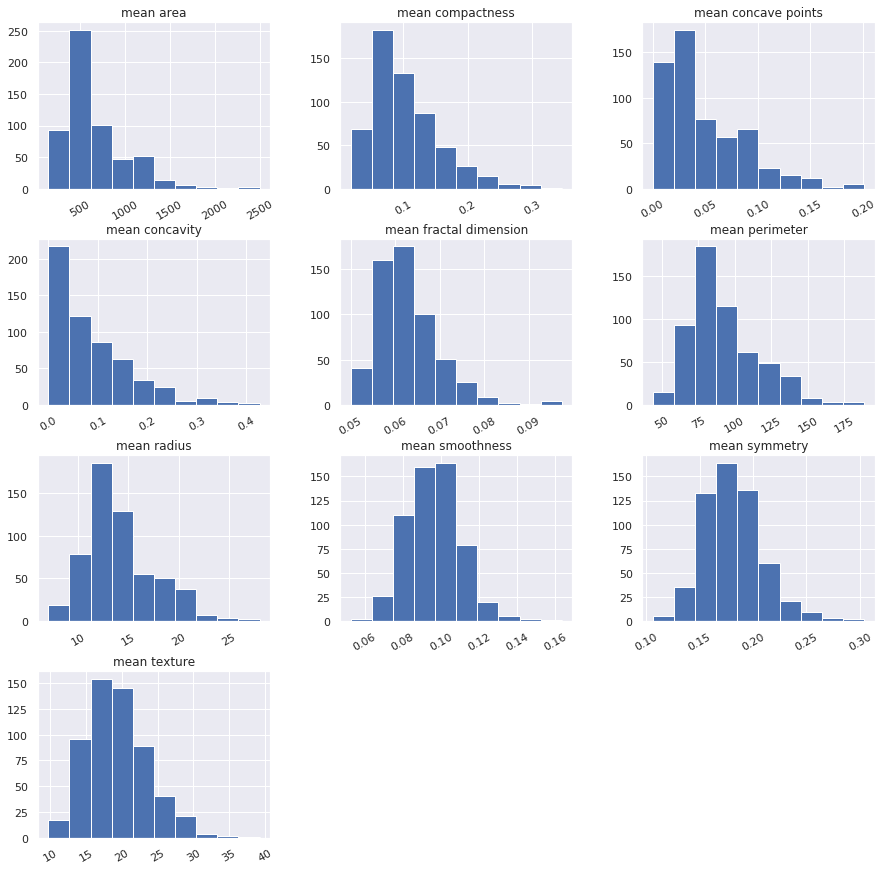

In [31]:
X.hist(figsize=(15,15), layout=(4,3), xrot=30)

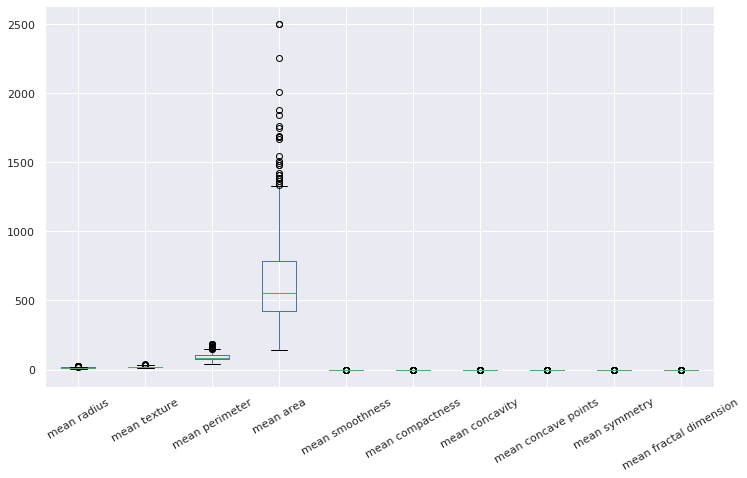

In [32]:
X.boxplot(figsize=(12,7),rot=30)

On observe que tous les attributs ne sont pas tous à la même échelle, et que notamment l'attribut "mean area" contient des valeurs bien plus élevées que les autres attributs. Cela pose un problème car des variations relatives faibles pour cet attribut (i.e. n'encodant pas un signal en terme de classification) vont apparaitre comme significative comparé aux autres attributs.

Pour ne pas souffrir de ce problème l'approche classique consiste à standardiser les attributs, de sorte que chaque attribut ait une moyenne de 0 et une variance de 1. Référez-vous aux transparents pour une explication plus détaillée. Cette opération s'appelle aussi <a href="https://fr.wikipedia.org/wiki/Variable_centr%C3%A9e_r%C3%A9duite">Centrer-Réduire</a>.

### Standardisation des données

On crée une matrice Xstd obtenue en standardisant X. A partir de maintenant on travaillera sur cette matrice.

In [33]:
from sklearn import preprocessing

Xstd = pa.DataFrame(preprocessing.scale(X), columns = ATTRIBUTS)

In [34]:
Xstd.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450


Générons de nouveau des diagrammes boxplot pour verifier qu'on a bien atténué l'effet "écrasant" de l'attribut rayon moyen.

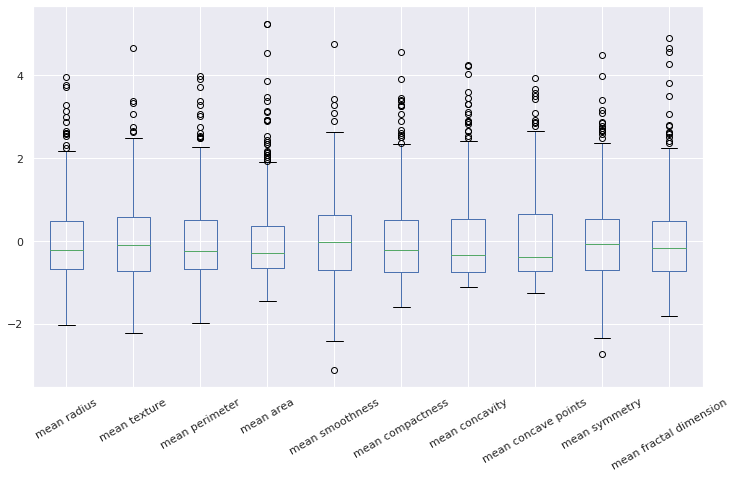

In [35]:
Xstd.boxplot(figsize=(12,7),rot=30)

On observe que les attributs semblent maintenant se comporter de manière relativement uniforme.

## Une premiere tentative de classification, visuelle, utilisant au plus deux attributs

On veut maintenant représenter graphiquement pour chaque paire d'attributs les points de données coloriés par classe de la tumeur, de manière à voir si il semble exister un ou deux attributs permettant de bien classifier, i.e. tels que les données des deux classes sont bien séparées.

In [36]:
# Pour cela on cree d'abord une data frame panda regroupant les attributs et la nature de la tumeur
Xstd_df = pa.DataFrame(Xstd, columns=ATTRIBUTS )
Xstd_df['target'] = y01
Xstd_df['label']  = Xstd_df.apply(lambda x: breast_cancer['target_names'][int(x.target)], axis=1)

In [37]:
Xstd_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,target,label
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,0,malignant
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0,malignant
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,0,malignant
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0,malignant
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,0,malignant


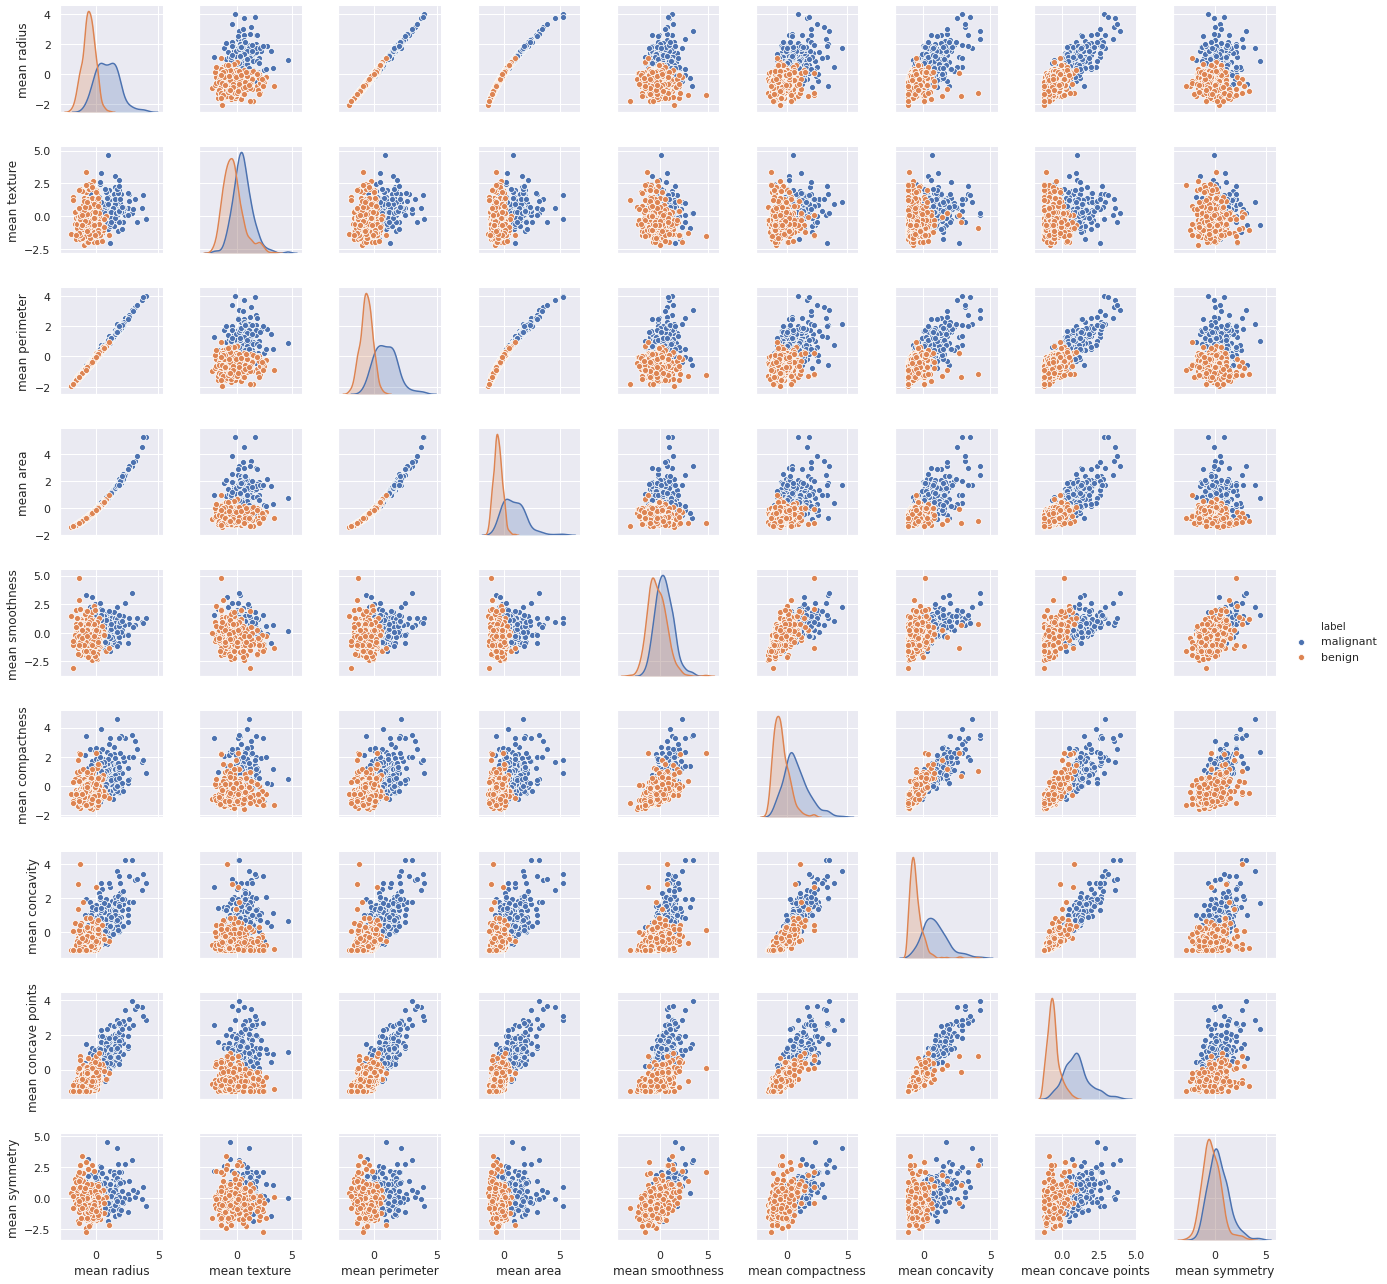

In [18]:
# Puis on utilise la fonction pairplot de seaborn
sns.pairplot(Xstd_df, hue='label', vars=breast_cancer.feature_names[0:9], height=2);

On peut observer que certaines paires d'attributs semblent bien séparer les données des deux classes. Ces paires d'attributs correspondent aux graphes où on observe deux groupes de points, un groupe de points bleus et un groupe de points oranges. Par exemple, *mean perimiter* et *mean texture*. D'autres paires d'attributs ne permettent pas d'observer une telle séparation, par exemple *mean smoothness* et *mean symmetry*. Néammoins il semble qu'il y'a un bon signal de classification dans ce jeu de données de dimension 10 (on a 10 attributs).

## Classification avec KNN

Comme dans notre premier calepin, on va utiliser l'algorithme k-nearest-neighbors pour développer notre classifieur. 

In [120]:
from sklearn import neighbors
from sklearn import metrics

# Classification avec KNN; on ne retourne que les statistiques exactitude et F1
def clf_knn_train(X,y):
    # Creation d'un classifieur KNN avec parameters par defaut
    clf_knn = neighbors.KNeighborsClassifier()
    # Entrainement du classifieur avec les donnees d'entrainement
    classifieur = clf_knn.fit(X,y)
    return(classifieur)

def clf_knn_test(clf,X,y):
    # Application du classifieur entraine sur les donnees de test
    predictions = clf.predict(X)
    # Calcul de deux metriques de performances du classifieur : exactitude et score F1
    F1          = metrics.f1_score(y, predictions)
    exactitude  = metrics.accuracy_score(y, predictions)
    # On renvoie les deux statistiques exactitute et score F1
    return({'F1':round(F1,4),'exactitude':round(exactitude,4)})

def clf_knn(X_train,y_train,X_test,y_test):
    # Entrainement du classifieur
    classifieur = clf_knn_train(X_train,y_train)
    # Test du classifieur
    resultats   = clf_knn_test(classifieur,X_test,y_test)
    return(resultats)

On partage aléatoirement nos données en données d'apprentissage et données de test.

In [150]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xstd, y, random_state=1)
y01_train = np.squeeze([x for [x] in np.array(y_train)])
y01_test  = np.squeeze([x for [x] in np.array(y_test)])

On applique l'algorithme KNN sur deux ttributs choisis arbitrairement.

In [138]:
ATT2_ex     = ['mean radius','mean perimeter']
ATT2_ex_knn = clf_knn(X_train[ATT2_ex],y01_train,X_test[ATT2_ex],y01_test)
print('Classification en utilisant mean radius/mean perimeter : exactitude='+str(ATT2_ex_knn['exactitude'])+'\tF1='+str(ATT2_ex_knn['F1']))

Classification en utilisant mean radius/mean perimeter : exactitude=0.9441	F1=0.9545


Maintenant, on considére toutes les paires d'attributs et on graphe une boîte à moustache des scores F1 et d'exactitude.

In [139]:
F1_ATT2         = {}
EXACTITUDE_ATT2 = {}
ATT_PAIRES      = []
for att1 in ATTRIBUTS:
    for att2 in ATTRIBUTS:
        if att1>att2:
            ATT_PAIRES.append((att1,att2))
for ATT2 in ATT_PAIRES:
        ATT2_knn              = clf_knn(X_train[[ATT2[0],ATT2[1]]],y01_train,X_test[[ATT2[0],ATT2[1]]],y01_test)
        F1_ATT2[ATT2]         = ATT2_knn['F1'] 
        EXACTITUDE_ATT2[ATT2] = ATT2_knn['exactitude']         

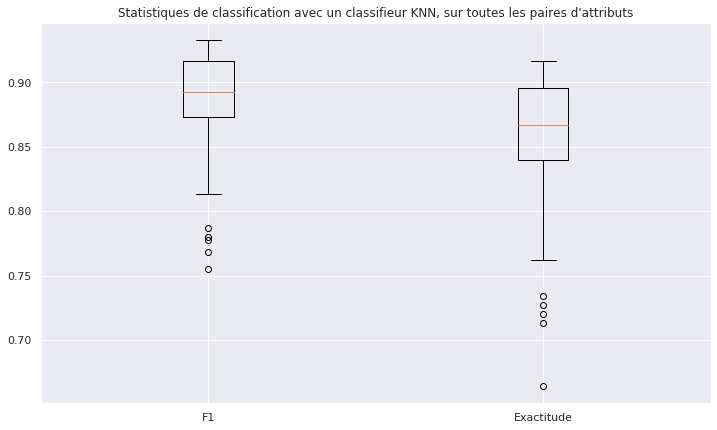

In [140]:
plt.figure(figsize=(12,7))
plt.boxplot([list(F1_ATT2.values()),list(EXACTITUDE_ATT2.values())],
           labels=['F1','Exactitude'])
plt.title('Statistiques de classification avec un classifieur KNN, sur toutes les paires d\'attributs')
plt.show()

On peut observer une grande variation de la qualité de prédiction en fonction des paires d'attributs pris en compte, certains menant à une classification presque parfaite, alors que d'autres ont des scores de l'ordre de 65%, ce qui est mauvais pour une question aussi importante que déterminer si une tumeur est maligne ou benigne. Cela suggeste que certains attributs sont non-informatifs et vont diluer le signal de classification.

Essayons de trouver la paire d'attributs ayant la meilleure exactitude, la pire exactitude, le meilleur score F1, le pire score F1.

In [141]:
print('Meilleur exactitude :\t',max(EXACTITUDE_ATT2, key=EXACTITUDE_ATT2.get), max(EXACTITUDE_ATT2.values()))
print('Meilleur score F1 :\t',max(F1_ATT2, key=F1_ATT2.get), max(F1_ATT2.values()))
print()
print('Pire exactitude :\t',min(EXACTITUDE_ATT2, key=EXACTITUDE_ATT2.get), min(EXACTITUDE_ATT2.values()))
print('Pire score F1 :\t\t',min(F1_ATT2, key=F1_ATT2.get), min(F1_ATT2.values()))

Meilleur exactitude :	 ('mean symmetry', 'mean area') 0.9161
Meilleur score F1 :	 ('mean symmetry', 'mean area') 0.9326

Pire exactitude :	 ('mean symmetry', 'mean smoothness') 0.6643
Pire score F1 :		 ('mean symmetry', 'mean smoothness') 0.7551


In [142]:
ATT2_best      = ['mean symmetry', 'mean area']
ATT2_best_knn  = clf_knn(X_train[[ATT2_best[0],ATT2_best[1]]],y01_train,X_test[[ATT2_best[0],ATT2_best[1]]],y01_test)

## Réduction de la dimensionalité avec ACP

In [143]:
from sklearn.decomposition import PCA

Pour conclure, on va appliquer la technique de l'Analyse en Composantes Principales à nos données pour voir si on cette approche permet de ramener notre problème de classification en un problème en deux dimensions, tout en maintenant de bonnes performances.

On reprend le code de notre premier calepin.

In [144]:
# On importe le module scikit-learn permettant d'effectuer une ACP
from sklearn.decomposition import PCA

# Classification KNN avec ACP
def clf_knn_acp(X_train,y_train,X_test,y_test,d):
    # On instancie un objet permettant d'effectuer une ACP en deux dimensions
    red_ACP  = PCA(n_components=d)
    # On calcule la matrice de changement de base et on transforme X_train en X_train_acp
    X_train_acp = red_ACP.fit_transform(X_train)
    # On transforme maintenant X_test
    X_test_acp  = red_ACP.transform(X_test)
    # Entrainement du classifieur
    classifieur = clf_knn_train(X_train_acp,y_train)
    # Test du classifieur
    resultats   = clf_knn_test(classifieur,X_test_acp,y_test)
    return(resultats)

In [147]:
print('Meilleure classification avec 2 attributs :\t exactitude='+str(ATT2_best_knn['exactitude'])+'\tF1='+str(ATT2_best_knn['F1']))
ACP2_knn  = clf_knn_acp(X_train,y01_train,X_test,y01_test,2)
print('Classification avec l\'ACP a 2 composantes principales :\t exactitude='+str(ACP2_knn['exactitude'])+'\tF1='+str(ACP2_knn['F1']))

Meilleure classification avec 2 attributs :	 exactitude=0.9161	F1=0.9326
Classification avec l'ACP a 2 composantes principales :	 exactitude=0.9371	F1=0.9503


On observe une amélioration notable (près de 2%) des performances en utilisant les deux premières composantes principales comparé aux deux meilleurs attributs. Cela est du au fait que l'ACP a pu aggréger en deux dimensions le signal de classification réparti dans plusieurs attributs.